# Pretraining on unlabelled data

In [1]:
import matplotlib.pyplot as plt
import torch
import warnings

from scratch.tokenizers.tiktoken_tokenizer import TiktokenTokenizer
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

In [2]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

In [3]:
tokenizer = TiktokenTokenizer()

inputs = torch.cat(
    (
        tokenizer.text_to_tokens('every effort moves'),
        tokenizer.text_to_tokens('I really like')
    )
)

targets = torch.cat(
    (
        tokenizer.text_to_tokens(' effort moves you'),
        tokenizer.text_to_tokens(' really like chocolate')
    )
)

In [4]:
config = GptConfig.small()
model = GptModel(config)

In [5]:
with torch.no_grad():
    logits = model(inputs)

In [6]:
# Why are we doing a softmax, here?
probas = torch.softmax(logits, dim=-1)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

In [7]:
# We should obtain the same result without the softmax normalization
token_ids = torch.argmax(logits, dim=-1, keepdim=True)

In [8]:
for batch_id, target in enumerate(targets):
    print("")
    print("Batch:", batch_id + 1)
    print("- Input:", tokenizer.tokens_to_text(inputs[batch_id]))
    print("- Target:", tokenizer.tokens_to_text(target))
    print("- Output:", tokenizer.tokens_to_text(token_ids[batch_id].flatten()))


Batch: 1
- Input: every effort moves
- Target:  effort moves you
- Output:  upon RW Possibly

Batch: 2
- Input: I really like
- Target:  really like chocolate
- Output:  unequivocally hierarchy immersive


In [9]:
for batch_id, target in enumerate(targets):
    print("")
    print("Batch:", batch_id + 1)
    print("- Probabilities:", probas[batch_id, [0, 1, 2], targets[batch_id]].tolist())


Batch: 1
- Probabilities: [1.2175913980172481e-05, 9.593678441888187e-06, 1.4175414435158018e-05]

Batch: 2
- Probabilities: [9.530353963782545e-06, 3.4648797736736014e-05, 9.837138350121677e-06]


In [10]:
def plot_probabilities(batch_id):
    fig, ax = plt.subplots()
    
    x = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in targets[batch_id]]
    y = probas[batch_id, [0, 1, 2], targets[batch_id]].tolist()
    
    ax.bar(x, y, color='green')
    ax.set_title('Probabilities before training for batch ' + str(batch_id + 1))
    fig.show()

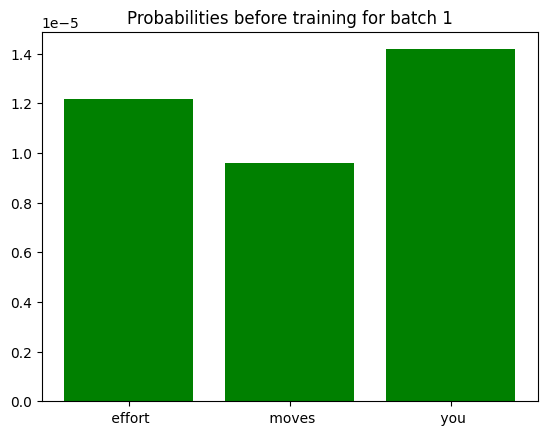

In [11]:
plot_probabilities(batch_id=0)

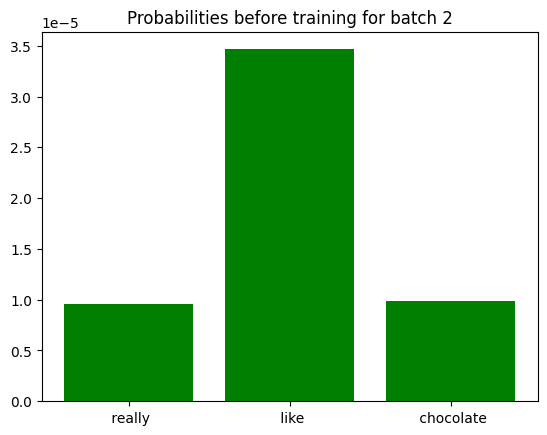

In [12]:
plot_probabilities(batch_id=1)

In [13]:
def plot_contextualized_probabilities(batch_id):
    fig, ax = plt.subplots()
    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    batch_words = targets[batch_id]
    other_words = torch.randint(0, config.vocab_size - 1, (6,))

    batch_tokens = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in batch_words]
    other_tokens = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in other_words]
    x = batch_tokens + other_tokens
    
    batch_probas = probas[batch_id, [0, 1, 2], batch_words].tolist()
    other_probas = probas[batch_id, 0, other_words].tolist()
    y = batch_probas + other_probas

    batch_color = ['green' for _ in batch_words]
    other_color = ['red' for _ in other_words]
    c = batch_color + other_color
    
    ax.bar(x, y, color=c)
    ax.set_title('Probabilities before training for batch ' + str(batch_id + 1))
    fig.show()

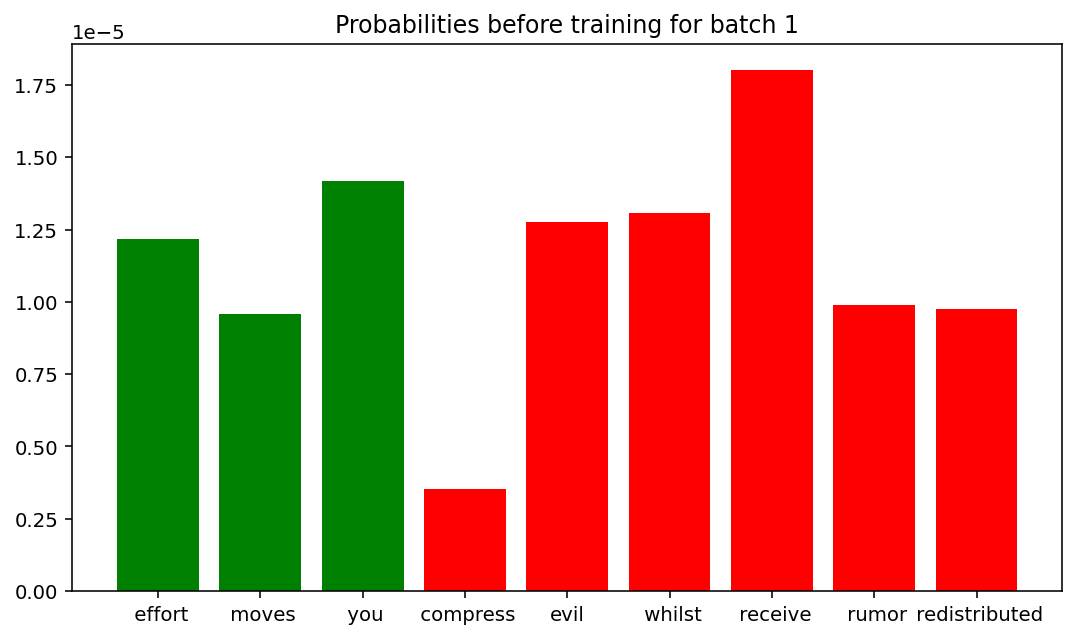

In [14]:
plot_contextualized_probabilities(batch_id=0)

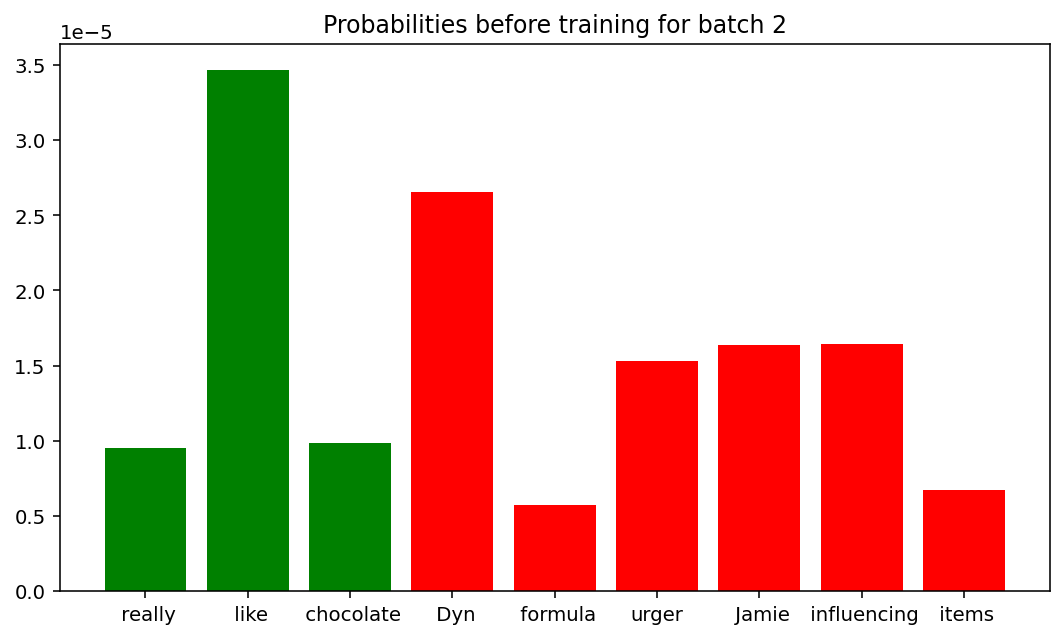

In [15]:
plot_contextualized_probabilities(batch_id=1)

## Text evaluation

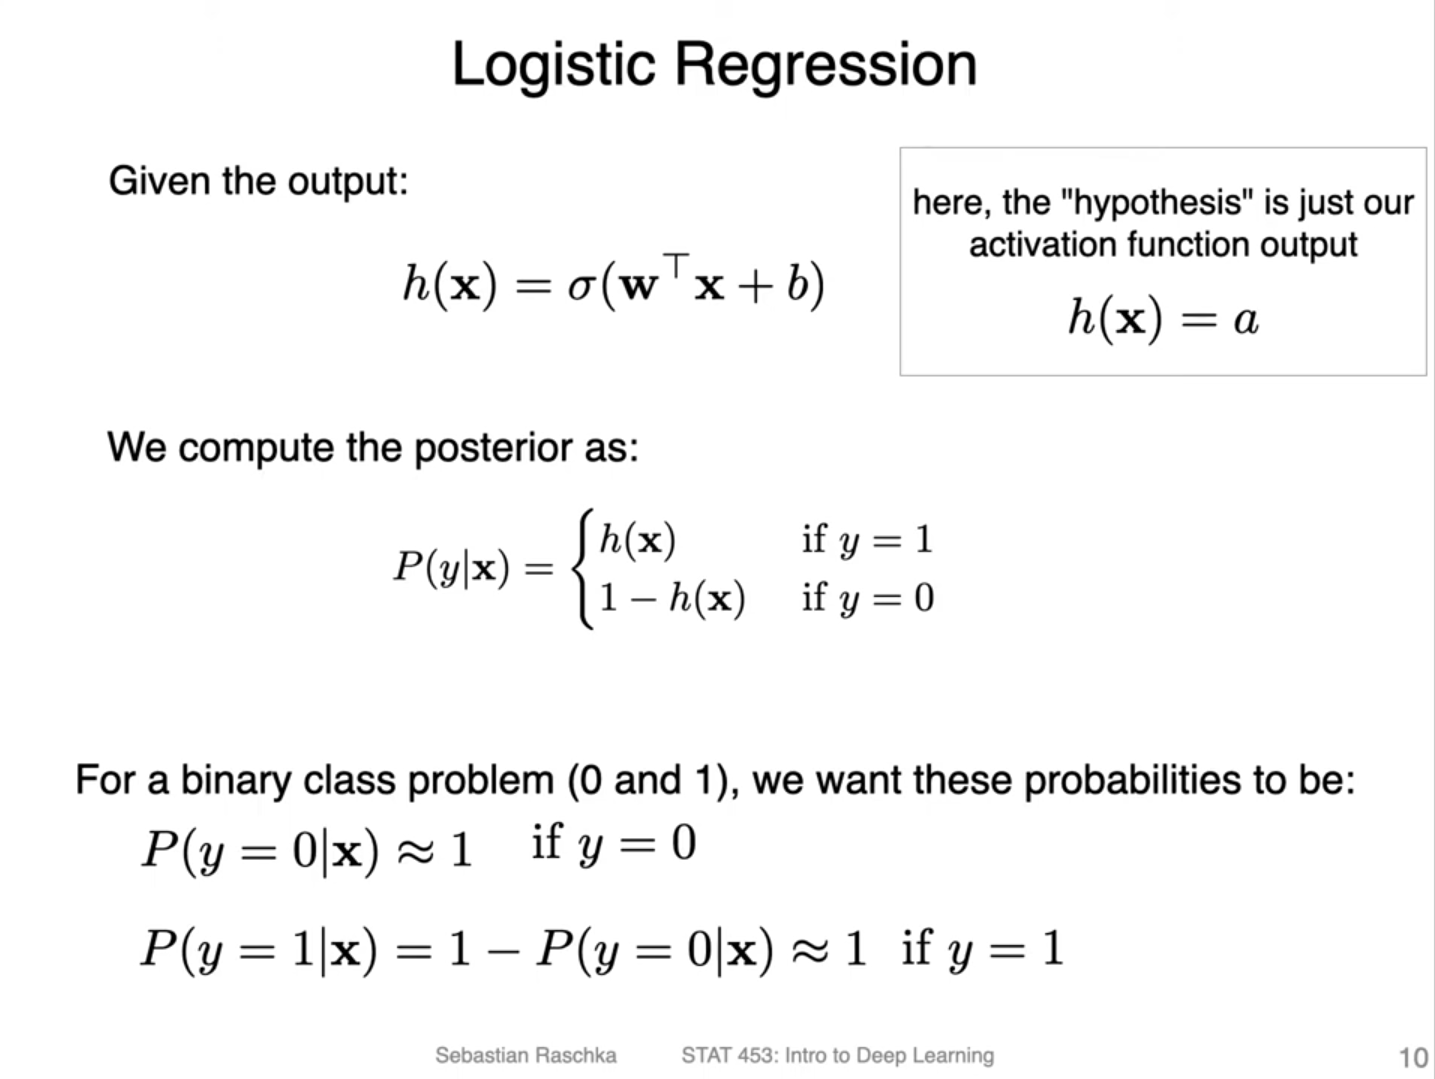